# Jux Tutorial

JUX is a jax-accelerated game core for Lux AI Challenge Season 2. This tutorial will guide you through the usage of JUX. Make sure you have fully understand [game rules](https://www.lux-ai.org/specs-2022-beta) of Lux AI Challenge Season 2 before going through this tutorial. This tutorial requires you to have basic knowledge of JAX.

In [ ]:
# rich is needed by this tutorial for nice printing
%pip install rich

# The Art of Dancing with Shackles

Programming in JAX is an art of dancing with shackles.

JAX in nature is a library aimed for array manipulation, not for general purpose programming. Programming in JAX is quite different from normal programming paradigm, and sometimes painful. Nearly all weird APIs you encountered in JUX are due to some limitation JAX exerts on us. Here are some of them:

1. We need to map all if-else, for-loop, and other normal statements to JAX's **array operators**. Good news is that this part is done in JUX, and you don't need to worry about it.

2. We need to adopt a **functional programming style**, which means we need to avoid mutating variables, and use immutable data structures. Every time you want to change a field of a class, you need to create a new instance of that class. This explains why you must pass in current game state to every function in JUX, and receive a new game state from them.

3. We have **no advanced data structures** like list, dict, set, etc. All we have is just array, and we need to imitate all kinds of data structures with array.

4. We must adopt a strange **attribute-first memory layout**, which is counter-intuitive for most programmers at first glance, but it is the key to understand the game state object.

5. To make functions jittable, all arrays must be of **static shape and dtype**. In other word, we have no stuff like lists with dynamic length. Every list must be of fixed length. If not, pad it to a fixed length, and use another variable to record the actual length.

But, what can we get from JAX? The answer is the massive parallel computation power and perfect portability. We need not to write any CUDA kernels or even any C++ code to enjoy the power of GPU. The whole project is implemented in pure python, so it can run on Linux/Windows/MacOS, and on CPU/GPU/TPU or any other XLA-compatible devices. This is cool, isn't it?

## Create a New Environment

We first create a new `JuxEnv` object. This object is analogous to a `LuxAI_S2`.

In [2]:
from jux.env import JuxEnv
from jux.config import JuxBufferConfig, EnvConfig

jux_env = JuxEnv(
    env_cfg=EnvConfig(),
    buf_cfg=JuxBufferConfig(MAX_N_UNITS=200),
)

jux_env.buf_cfg

JuxBufferConfig(MAX_N_UNITS=200, MAX_GLOBAL_ID=2000, MAX_N_FACTORIES=6, MAP_SIZE=48)

Beside the `EnvConfig` configuration, we also need to specify the `JuxBufferConfig`. The most important parameter is the `MAX_N_UNITS`, which greatly affects the performance and memory usage. The default value is 1000. See the performance section in [README.md](README.md#performance) for more details.

Then, we reset the environment.

In [3]:
state = jux_env.reset(seed=0)

The `reset()` function returns a `State` object, which stores the the current state of the game. Since LuxAI_S2 is a perfect information game, the `State` object is also our initial observation. The first time we call `reset()` takes several seconds for jax to compile it, and subsequent calls will be finished on the fly. Please run above cell again to see the difference.

We can visualize the game state by following code snippet. 

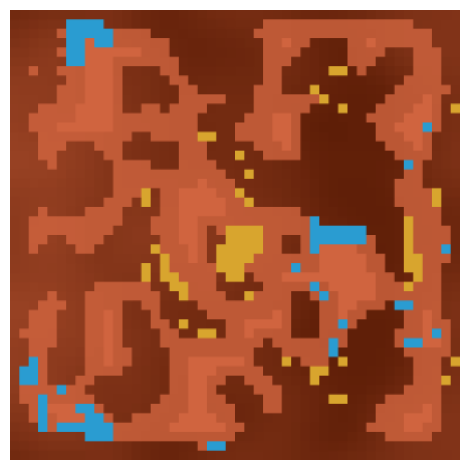

In [4]:
import matplotlib.pyplot as plt
img = jux_env.render(state, "rgb_array")
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.show()

## Step the Environment

Let's first load a replay, and create our `JuxEnv` and `State` from it.

In [5]:
import jux.utils

episode = '45740641'
lux_env, lux_actions = jux.utils.load_replay(f'https://www.kaggleusercontent.com/episodes/{episode}.json')

jux_env, state = JuxEnv.from_lux(lux_env, buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))

This section we show how to step the environment. LuxAI_S2 has three phases:
1. the initial bid step
2. the factory placement steps
3. the normal steps

To deal with three different phases, the `LuxAI_S2.step()` function is replaced with three phase-specific step functions:
1. `JuxEnv.step_bid()`
2. `JuxEnv.step_factory_placement()`
3. `JuxEnv.step_late_game()`

Each of them has unique signature and deal a specific game phase.

### Bid Step

The first step is bid step, which is handled by `JuxEnv.step_bid()`. Jax adopts a functional programming style, so `JuxEnv` stores nothing about the game state. Every time we call `step_bid()`, the current game state shall be passed in, and a new game state is passed out. The same rule also applies to `step_factory_placement()` and `step_late_game()`.

In [6]:
import jux.actions
from pprint import pprint

lux_act = next(lux_actions)

print("bid action in Lux:")
pprint(lux_act, compact=False)

bid, faction = jux.actions.bid_action_from_lux(lux_act)
print()
print("bid action in Jux:")
print(f"{bid = !s}, {faction = !s}")

state, (observations, rewards, dones, infos) = jux_env.step_bid(state, bid, faction)

bid action in Lux:
{'player_0': {'bid': 0, 'faction': 'AlphaStrike'},
 'player_1': {'bid': 0, 'faction': 'AlphaStrike'}}

bid action in Jux:
bid = [0 0], faction = [0 0]


The argument `bid` and `faction` shall have following shapes.

In [7]:
print(f"bid: {bid.aval}")
print(f"faction: {faction.aval}")

bid: ShapedArray(int32[2])
faction: ShapedArray(int8[2])


There are four factions, numbered from 0 to 3.

In [8]:
from jux.team import FactionTypes

{int(f): f for f in FactionTypes}

{0: <FactionTypes.AlphaStrike: 0>,
 1: <FactionTypes.MotherMars: 1>,
 2: <FactionTypes.TheBuilders: 2>,
 3: <FactionTypes.FirstMars: 3>}

Beside new game state, there are also other four return values, `observations`, `rewards`, `dones`, and `infos`.
1. `observations` contains the observations for each player. Since LuxAI_S2 is a perfect information game, the observations are simply the same `state` object, i.e., 
    ```python
    observations['player_0'] == observations['player_1'] == state
    ```
2. `rewards` contains the sum of lichens each player owns.
3. `dones` is a dictionary of boolean values, which indicates whether the game is over for each player. It is gaurenteed that 
    ```python
    dones['player_0'] == dones['player_1']
    ```
4. `infos` for each player is an empty dictionary, because there is no other infos to provide. 
    ```python
    infos['player_0'] == infos['player_1'] == {}
    ```

### Factory Placement Steps

The factory placement step is handled by `JuxEnv.step_factory_placement()`. The next player to place a factory is indicated by `state.next_player`.

In [9]:
while state.real_env_steps < 0:
    lux_act = next(lux_actions)
    print(f"{lux_act = }")
    spawn, water, metal = jux.actions.factory_placement_action_from_lux(lux_act)

    print(f"player_{state.next_player!s} place a factory at {spawn[state.next_player]}",
          f"with water={water[state.next_player]}, metal={metal[state.next_player]}.")
    state, (observations, rewards, dones, infos) = jux_env.step_factory_placement(state, spawn, water, metal)

lux_act = {'player_0': {'metal': 150, 'spawn': [5, 43], 'water': 150}, 'player_1': {}}
player_0 place a factory at [ 5 43] with water=150, metal=150.
lux_act = {'player_0': {}, 'player_1': {'metal': 100, 'spawn': [23, 42], 'water': 100}}
player_1 place a factory at [23 42] with water=100, metal=100.
lux_act = {'player_0': {'metal': 150, 'spawn': [17, 9], 'water': 150}, 'player_1': {}}
player_0 place a factory at [17  9] with water=150, metal=150.
lux_act = {'player_0': {}, 'player_1': {'metal': 100, 'spawn': [8, 22], 'water': 100}}
player_1 place a factory at [ 8 22] with water=100, metal=100.
lux_act = {'player_0': {'metal': 150, 'spawn': [2, 24], 'water': 150}, 'player_1': {}}
player_0 place a factory at [ 2 24] with water=150, metal=150.
lux_act = {'player_0': {}, 'player_1': {'metal': 100, 'spawn': [20, 4], 'water': 100}}
player_1 place a factory at [20  4] with water=100, metal=100.


The argument `spawn`, `water`, and `metal` have a leading dimension 2, but only 
- `spawn[state.next_player]`
- `water[state.next_player]`
- `metal[state.next_player]`

are used.

In [10]:
print(f"spawn: {spawn.aval}")
print(f"water: {water.aval}")
print(f"metal: {metal.aval}")

spawn: ShapedArray(int8[2,2])
water: ShapedArray(int32[2])
metal: ShapedArray(int32[2])


This is the current game state.

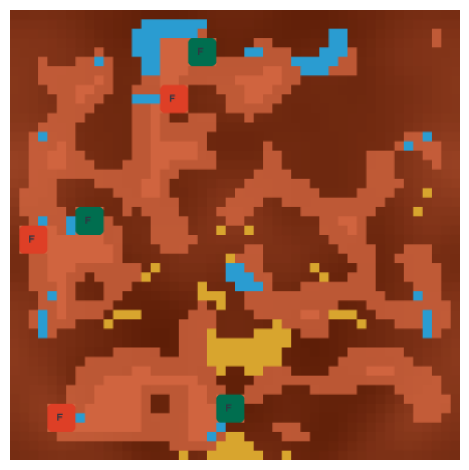

In [11]:
img = jux_env.render(state, "rgb_array")
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.show()

### Normal Steps

The normal steps are handled by `JuxEnv.step_late_game()`.

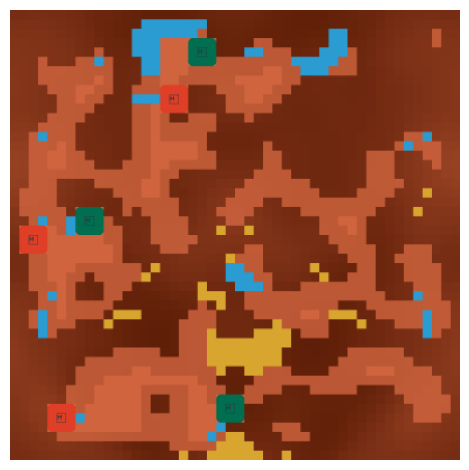

In [12]:
from jux.actions import JuxAction
# prepare actions
lux_act = next(lux_actions)
jux_act = JuxAction.from_lux(state, lux_act)

# step
state, (observations, rewards, dones, infos) = jux_env.step_late_game(state, jux_act)

# render
img = jux_env.render(state, "rgb_array")
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.show()

`step_late_game()` takes an `JuxAction` object as input, which will be elaborated lately. The first time we call `step_late_game()` triggers the jax jit compilation, which is slow, but subsequent calls will be finished on the fly. You may run above cell again to see the difference.

## Understanding the `State`

`State` object is a nested `NamedTuple`, with all leaves being `jax.numpy.ndarray`. It has following fields. 

In [13]:
state._fields

('env_cfg',
 'seed',
 'rng_state',
 'env_steps',
 'board',
 'weather_schedule',
 'units',
 'unit_id2idx',
 'n_units',
 'factories',
 'factory_id2idx',
 'n_factories',
 'teams',
 'global_id',
 'place_first')

### Board Information

Information about the board, including rubble, ice, ore, and lichen, are stored in `state.board`.

In [14]:
import jux.tree_util
import rich
rich.print(jux.tree_util.map_to_aval(state.board))

Board(
    seed=ShapedArray(int32[], weak_type=True),
    factories_per_team=ShapedArray(int8[]),
    map=GameMap(
        rubble=ShapedArray(int8[48,48]),
        ice=ShapedArray(bool[48,48]),
        ore=ShapedArray(bool[48,48]),
        symmetry=ShapedArray(int8[])
    ),
    lichen=ShapedArray(int32[48,48]),
    lichen_strains=ShapedArray(int8[48,48]),
    units_map=ShapedArray(int16[48,48]),
    factory_map=ShapedArray(int8[48,48]),
    factory_occupancy_map=ShapedArray(int8[48,48]),
    factory_pos=ShapedArray(int8[12,2])
)

### Factory Information

All information about factories, including their position, cargo, and power, are stored in `state.factories`. `state.n_factories` indicates the number of factories each player has. Because we have just reset the environment, both players have 0 factory. The leaves of `state.factories` have shapes shown as below. 

In [15]:
print(f"{state.n_factories = }")
rich.print(jux.tree_util.map_to_aval(state.factories))

state.n_factories = DeviceArray([3, 3], dtype=int8)


Factory(
    team_id=ShapedArray(int8[2,6]),
    unit_id=ShapedArray(int8[2,6]),
    pos=Position(pos=ShapedArray(int8[2,6,2])),
    power=ShapedArray(int32[2,6]),
    cargo=UnitCargo(stock=ShapedArray(int32[2,6,4]))
)

All leaves of `state.factories` have leading dimensions of `(2, MAX_N_FACTORIES)`. Data of player 0 are stored in `state.factories.xxx[0]` and data of player 1 are stored in `state.factories.xxx[1]`.

Assume `state.n_factories` is `[2, 3]`, then player 0 has 2 factories, and player 1 has 3 factories. For player 0, the 2 factories he/she owns have power `state.factories.power[0, 0]` and `state.units.factories[0, 1]`, respectively. All values in `state.factories.power[0, 2:]` are invalid and undefined, because player 0 only has 2 factories. The same rule applies to other fields in `state.factories`. 

#### Memory layout: Object-frist vs Attribute-first
The memory layout of `state.factories` is different from the classic object-oriented programming style. Take power as an example, the power of all units are stored in a single array. We call such kind of memory layout **attribute-first**, because it arranges the same attributes of all objects into consecutive memory space. 

In classic object-oriented programming, if we have a list of objects, we usually stores all attributes of an object in a single memory block, and maintain a list of such memory block. It usually looks like this:
```python
[
    Factory(unit_id=0, power=0, ... ),
    Factory( ... ),
    Factory( ... ),
    Factory( ... ),
    ...
]
```
This is called **object-first** memory layout, because it arranges the same object into consecutive memory space.

In **attribute-first** layout, we only have one `Factory` object, but its attributes have a leading batch dimension. It looks like this:
```python
Factory(
    unit_id=[0, 1, 2, 3, ...],
    power=[0, 0, 0, 0, ...],
    ...
)
```

The biggest advantage of attribute-first layout is that it is array-friendly. We can use array operations to manipulate the data. For example, we can implement factory power gain by a simple vector addition. 
```python
new_power = state.factories.power + state.env_cfg.FACTORY_CHARGE
```

### Unit Information

Information about units, including their unit type, position, cargo, and power, are stored in `state.units`. `state.n_units` indicates the number of units each player has. The leaves of `state.units` have shapes shown as below. Similar as factories, units are also stored in attribute-first layout. All leaves of `state.units` have leading dimensions of `(2, MAX_N_UNITS)`. More info about `state.units.action_queue` will be elaborated in .

In [16]:
print(f"{state.n_units = }")
rich.print(jux.tree_util.map_to_aval(state.units))

state.n_units = DeviceArray([3, 3], dtype=int16)


Unit(
    unit_type=ShapedArray(int8[2,200]),
    action_queue=ActionQueue(
        data=UnitAction(
            action_type=ShapedArray(int8[2,200,20]),
            direction=ShapedArray(int8[2,200,20]),
            resource_type=ShapedArray(int8[2,200,20]),
            amount=ShapedArray(int16[2,200,20]),
            repeat=ShapedArray(int8[2,200,20])
        ),
        front=ShapedArray(int8[2,200]),
        rear=ShapedArray(int8[2,200]),
        count=ShapedArray(int8[2,200])
    ),
    team_id=ShapedArray(int8[2,200]),
    unit_id=ShapedArray(int16[2,200]),
    pos=Position(pos=ShapedArray(int8[2,200,2])),
    cargo=UnitCargo(stock=ShapedArray(int32[2,200,4])),
    power=ShapedArray(int32[2,200])
)

## Understanding Robot Actions

The whole actions system is designed upon three classes `UnitAction`, `ActionQueue` and `JuxActions`.
1. `UnitAction`: the class representing single robot action.
2. `ActionQueue`: a bi-directional queue storing a sequence of actions.
3. `JuxActions`: a NamedTuple containing both actions for factories and robots, mainly used as input to `JuxEnv.step_late_game()`.


### UnitAction

Actions of robots are represented by `UnitAction` objects. There are five fields in `UnitAction`:

| fields          | dtype | description                                          |
|:--------------- |:----- |:---------------------------------------------------- |
| `action_type`   | int8  | indicates the action type.                           |
| `direction`     | int8  | used in `MOVE` and `TRANSFER` actions.               |
| `resource_type` | int8  | used in `PICKUP` and `TRANSFER` actions.             |
| `amount`        | int16 | used in `PICKUP`, `TRANSFER` and `RECHARGE` actions. |
| `repeat`        | int8  | used in all actions.                                 |
| `n`             | int16 | used in all actions.                                 |

In [17]:
from jux.map.position import Direction
from jux.actions import UnitAction
import rich

move_action = UnitAction.move(Direction.UP, repeat=0)
rich.print(move_action)

UnitAction(
    action_type=DeviceArray(0, dtype=int8),
    direction=DeviceArray(1, dtype=int8),
    resource_type=DeviceArray(0, dtype=int8),
    amount=DeviceArray(0, dtype=int16),
    repeat=DeviceArray(0, dtype=int8)
)

`action_type` must be one of `UnitActionType`. There are 6 types of actions, numbered from 0 to 5. Note: `DO_NOTHING` (-1) is a special one, designed for internal use only. Users should not use it. 

In [18]:
from jux.actions import UnitActionType

{int(a): a for a in UnitActionType}

{-1: <UnitActionType.DO_NOTHING: -1>,
 0: <UnitActionType.MOVE: 0>,
 1: <UnitActionType.TRANSFER: 1>,
 2: <UnitActionType.PICKUP: 2>,
 3: <UnitActionType.DIG: 3>,
 4: <UnitActionType.SELF_DESTRUCT: 4>,
 5: <UnitActionType.RECHARGE: 5>}

`direction` must be one of `Direction`. There are 5 directions, numbered from 0 to 4.

In [19]:
from jux.map.position import Direction

{int(a): a for a in Direction}

{0: <Direction.CENTER: 0>,
 1: <Direction.UP: 1>,
 2: <Direction.RIGHT: 2>,
 3: <Direction.DOWN: 3>,
 4: <Direction.LEFT: 4>}

`resource_type` must be one of `ResourceType`. There are 4 types of resources, numbered from 0 to 3.

In [20]:
from jux.unit_cargo import ResourceType

{int(a): a for a in ResourceType}

{0: <ResourceType.ice: 0>,
 1: <ResourceType.ore: 1>,
 2: <ResourceType.water: 2>,
 3: <ResourceType.metal: 3>,
 4: <ResourceType.power: 4>}

### Action Queue

The most complicated part about `units` is its action queue. The action queue for single unit has following structure.

In [21]:
from jux.actions import ActionQueue
action_queue = ActionQueue.empty(capacity=state.env_cfg.UNIT_ACTION_QUEUE_SIZE)
rich.print(jux.tree_util.map_to_aval(action_queue))

ActionQueue(
    data=UnitAction(
        action_type=ShapedArray(int8[20]),
        direction=ShapedArray(int8[20]),
        resource_type=ShapedArray(int8[20]),
        amount=ShapedArray(int16[20]),
        repeat=ShapedArray(int8[20])
    ),
    front=ShapedArray(int8[]),
    rear=ShapedArray(int8[]),
    count=ShapedArray(int8[])
)

Units' actions are stored in `state.units.action_queue`, which is a bi-directional queue implemented in jax. `ActionQueue` has four fields: `data`, `count`, `front`, and `rear`. 
1. `data` is a `UnitAction` object, containing `UNIT_ACTION_QUEUE_SIZE` actions in attribute-first layout, so its attributes have a leading dimension of `UNIT_ACTION_QUEUE_SIZE`.
2. `count` indicates the number of actions in the queue.
3. `front` is the index of the first action in the queue. 
4. `rear` is the index of the first empty slot in the queue, which is also the position for next push back. `(rear - 1) % capacity` is the index of the last action in the queue.

Above is the structure of action queue for a single unit. Now, let's have a look at `state.units.action_queue`, which contains the action queue for all units. The main difference is that all leaves are added with two leading dimensions of `(2, MAX_N_UNITS)`. Again, this is because we use attribute-first layout.

In [22]:
rich.print(jux.tree_util.map_to_aval(state.units.action_queue))

ActionQueue(
    data=UnitAction(
        action_type=ShapedArray(int8[2,200,20]),
        direction=ShapedArray(int8[2,200,20]),
        resource_type=ShapedArray(int8[2,200,20]),
        amount=ShapedArray(int16[2,200,20]),
        repeat=ShapedArray(int8[2,200,20])
    ),
    front=ShapedArray(int8[2,200]),
    rear=ShapedArray(int8[2,200]),
    count=ShapedArray(int8[2,200])
)

`ActionQueue` provides several useful methods, such as `push_back()`, `push_front()`, `pop()` and `peek()`. However, all these methods can only be applied to the queues of a single unit. `state.units.action_queue` has two batch dimension, one for player, one for units, so we need to `vmap` these methods two times. The following code shows how to peek the next actions of all units. The returned `act` contains the next actions of all units, again, in attribute-first layout.

In [23]:
from jux.actions import ActionQueue
import jax
peek_vmap_vmap = jax.vmap(jax.vmap(ActionQueue.peek))
act = peek_vmap_vmap(state.units.action_queue)
rich.print(jux.tree_util.map_to_aval(act))

UnitAction(
    action_type=ShapedArray(int8[2,200]),
    direction=ShapedArray(int8[2,200]),
    resource_type=ShapedArray(int8[2,200]),
    amount=ShapedArray(int16[2,200]),
    repeat=ShapedArray(int8[2,200])
)

### JuxAction

`JuxAction` is a NamedTuple containing both actions for factories and robots, mainly used as input to `JuxEnv.step_late_game()`. It has four fields: `factory_actions`, `unit_action_queue`, `unit_action_queue_count` and `unit_action_queue_update`.
1. `factory_actions`: the actions for each factories.
2. `unit_action_queue_update`: a boolean array indicating whether a unit's action queue should be updated or not in this turn.
3. `unit_action_queue`: What actions will be in the new action queue, If update.
4. `unit_action_queue_count`: How many actions will there be in the new action queue, if update.

In [24]:
jux_act = JuxAction.from_lux(state, lux_act)
rich.print(jux.tree_util.map_to_aval(jux_act))

JuxAction(
    factory_action=ShapedArray(int8[2,6]),
    unit_action_queue=UnitAction(
        action_type=ShapedArray(int8[2,200,20]),
        direction=ShapedArray(int8[2,200,20]),
        resource_type=ShapedArray(int8[2,200,20]),
        amount=ShapedArray(int16[2,200,20]),
        repeat=ShapedArray(int8[2,200,20])
    ),
    unit_action_queue_count=ShapedArray(int8[2,200]),
    unit_action_queue_update=ShapedArray(bool[2,200])
)

There are four types of actions for factories: `DO_NOTHING`, `BUILD_LIGHT`, `BUILD_HEAVY` and `WATER`, numbered from -1 to 2.

In [25]:
from jux.actions import FactoryAction

{int(a): a for a in FactoryAction}

{-1: <FactoryAction.DO_NOTHING: -1>,
 0: <FactoryAction.BUILD_LIGHT: 0>,
 1: <FactoryAction.BUILD_HEAVY: 1>,
 2: <FactoryAction.WATER: 2>}

## Run a Batch of Environments
Running a single environment cannot take full advantage of the power of modern GPU. This section will show you how to run a batch of environments at once. We first create a `JuxEnvBatch` object.

In [26]:
from jux.env import JuxEnvBatch

jux_env_batch = JuxEnvBatch(buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))

Then, reset the environment to get initial states. Instead of passing in a single seed, we pass in a batch of seeds. The batch size is determined by the size of the seed array.

In [27]:
import jax.numpy as jnp

batch_size = 10
seeds = jnp.arange(batch_size)

states = jux_env_batch.reset(seeds)

According to our attribute-first memory layout, states is still a `State` object, but all leaves are added with a leading dimension of `batch_size`.

In [28]:
rich.print(jux.tree_util.map_to_aval(states.factories))

Factory(
    team_id=ShapedArray(int8[10,2,6]),
    unit_id=ShapedArray(int8[10,2,6]),
    pos=Position(pos=ShapedArray(int8[10,2,6,2])),
    power=ShapedArray(int32[10,2,6]),
    cargo=UnitCargo(stock=ShapedArray(int32[10,2,6,4]))
)

The states returned by `JuxEnvBatch.reset()` shares the same environmental config and jux buffer config. In addition, they are also guaranteed to have the same `states.board.factories_per_team`, so they take the same number of turns to place factories.

In [29]:
states.board.factories_per_team

DeviceArray([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

Similarly, other arguments of `JuxEnvBatch.step_*()` are also batched. All arrays must have a leading dimension of `batch_size`.

In [30]:
# bid step
bid = jnp.zeros((batch_size, 2), dtype=jnp.int32)
faction = jnp.zeros((batch_size, 2), dtype=jnp.int8)

states, (observations, rewards, dones, infos) = jux_env_batch.step_bid(states, bid, faction)

print(f"bid: {bid.aval}")
print(f"faction: {faction.aval}")

bid: ShapedArray(int32[10,2])
faction: ShapedArray(int8[10,2])


In [31]:
key = jax.random.PRNGKey(0)
water = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150
metal = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150

# factory placement step
factories_per_team = states.board.factories_per_team[0]
for i in range(factories_per_team * 2):
    # random spawn position
    key, subkey = jax.random.split(key)
    spawn = jax.random.randint(subkey, (batch_size, 2, 2), 0, jux_env_batch.env_cfg.map_size, dtype=jnp.int8)
    states, (observations, rewards, dones, infos) = jux_env_batch.step_factory_placement(states, spawn, water, metal)

print(f"spawn: {spawn.aval}")
print(f"water: {water.aval}")
print(f"metal: {metal.aval}")

spawn: ShapedArray(int8[10,2,2])
water: ShapedArray(int32[10,2])
metal: ShapedArray(int32[10,2])


In [32]:
# a dummy action
jux_action = JuxAction.empty(
    jux_env_batch.env_cfg, 
    jux_env_batch.buf_cfg
)
jux_action = jax.tree_map(lambda x: x[None].repeat(batch_size, axis=0), jux_action)
rich.print(jux.tree_util.map_to_aval(jux_action))

# late game step
states, (observations, rewards, dones, infos) = jux_env_batch.step_late_game(states, jux_action)

JuxAction(
    factory_action=ShapedArray(int8[10,2,6]),
    unit_action_queue=UnitAction(
        action_type=ShapedArray(int8[10,2,200,20]),
        direction=ShapedArray(int8[10,2,200,20]),
        resource_type=ShapedArray(int8[10,2,200,20]),
        amount=ShapedArray(int16[10,2,200,20]),
        repeat=ShapedArray(int8[10,2,200,20])
    ),
    unit_action_queue_count=ShapedArray(int8[10,2,200]),
    unit_action_queue_update=ShapedArray(bool[10,2,200])
)

## Convert between PyTorch and JAX

Since PyTorch is widely used in the community, we provide a simple way to convert between PyTorch and JAX. Following code shows how to convert observations (state) from JAX array to PyTorch tensor, so it can be feed into PyTorch models.

In [33]:
import jux.torch

# rng_state cannot be converted to torch
# remove env_cfg to reduce output size
torch_state = jax.tree_map(jux.torch.to_torch, states._replace(rng_state=None, env_cfg=None))
rich.print(jax.tree_map(lambda x: x.shape, torch_state))

State(
    env_cfg=None,
    seed=torch.Size([10]),
    rng_state=None,
    env_steps=torch.Size([10]),
    board=Board(
        seed=torch.Size([10]),
        factories_per_team=torch.Size([10]),
        map=GameMap(
            rubble=torch.Size([10, 48, 48]),
            ice=torch.Size([10, 48, 48]),
            ore=torch.Size([10, 48, 48]),
            symmetry=torch.Size([10])
        ),
        lichen=torch.Size([10, 48, 48]),
        lichen_strains=torch.Size([10, 48, 48]),
        units_map=torch.Size([10, 48, 48]),
        factory_map=torch.Size([10, 48, 48]),
        factory_occupancy_map=torch.Size([10, 48, 48]),
        factory_pos=torch.Size([10, 12, 2])
    ),
    weather_schedule=torch.Size([10, 1000]),
    units=Unit(
        unit_type=torch.Size([10, 2, 200]),
        action_queue=ActionQueue(
            data=UnitAction(
                action_type=torch.Size([10, 2, 200, 20]),
                direction=torch.Size([10, 2, 200, 20]),
                resource_type=torch.Size([10, 2, 200, 20]),
                amount=torch.Size([10, 2, 200, 20]),
                repeat=torch.Size([10, 2, 200, 20])
            ),
            front=torch.Size([10, 2, 200]),
            rear=torch.Size([10, 2, 200]),
            count=torch.Size([10, 2, 200])
        ),
        team_id=torch.Size([10, 2, 200]),
        unit_id=torch.Size([10, 2, 200]),
        pos=Position(pos=torch.Size([10, 2, 200, 2])),
        cargo=UnitCargo(stock=torch.Size([10, 2, 200, 4])),
        power=torch.Size([10, 2, 200])
    ),
    unit_id2idx=torch.Size([10, 2000, 2]),
    n_units=torch.Size([10, 2]),
    factories=Factory(
        team_id=torch.Size([10, 2, 6]),
        unit_id=torch.Size([10, 2, 6]),
        pos=Position(pos=torch.Size([10, 2, 6, 2])),
        power=torch.Size([10, 2, 6]),
        cargo=UnitCargo(stock=torch.Size([10, 2, 6, 4]))
    ),
    factory_id2idx=torch.Size([10, 12, 2]),
    n_factories=torch.Size([10, 2]),
    teams=Team(
        team_id=torch.Size([10, 2]),
        faction=torch.Size([10, 2]),
        init_water=torch.Size([10, 2]),
        init_metal=torch.Size([10, 2]),
        factories_to_place=torch.Size([10, 2]),
        factory_strains=torch.Size([10, 2, 6]),
        n_factory=torch.Size([10, 2])
    ),
    global_id=torch.Size([10]),
    place_first=torch.Size([10])
)

You can also convert PyTorch tensors to JAX arrays by `jux.torch.from_torch`. Typical usage is to convert actions generated by PyTorch models to JAX arrays, so they can be feed into `JuxEnv.step_*()`.

In [34]:
import torch

jux.torch.from_torch(torch.arange(10))

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

There is also a utility function `JuxAction.from_torch()` for build a valid `JuxAction` object from PyTorch tensors.